## Part 1.MNIST数据集的载入

In [ ]:
import torch
import numpy as np
from matplotlib import pyplot as plt
from torchvision.datasets import MNIST
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import torch.nn.functional as nf
from torch.utils.tensorboard import SummaryWriter
# 对数据进行归一化
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.1307,), (0.3081,))])
#导入MNIST数据集，数据集会下载到当前根目录(和本文件同一个目录的文件夹下)的data文件夹下
data_train = MNIST('./data', train = True, download=True, transform = transform)

data_test = MNIST('./data', train=False, download=True, transform= transform)
#分别创建两个DataLoader载入训练集与测试集的数据
# 注意batch-size表示每批样本的大小，一次训练迭代一个batch.因此len(data_train_loader)表示mini-batch的数目
#batch_idx表示batch批的数目下标
data_train_loader = DataLoader(data_train, batch_size=256 ,shuffle= True, num_workers=0)  # 训练集的数据被随机打乱
data_test_loader = DataLoader(data_test, batch_size=1024 , shuffle= False, num_workers=0) # 测试集数据不用做随机排列

## Part2.展示MNIST数据集

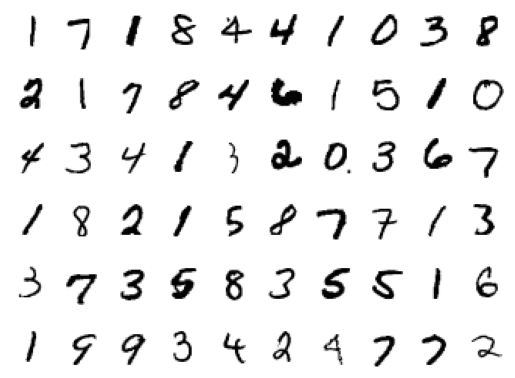

In [20]:
figure = plt.figure()
num_of_images = 60

for imgs, targets in data_train_loader:
    break
for index in range(num_of_images):  # 载入训练集index为0-59共60张图片
    plt.subplot(6, 10, index + 1)
    plt.axis("off")
    img = imgs[index, ...]
    plt.imshow(img.numpy().squeeze(), cmap='gray_r')
plt.show()

## Part3.构建CNN模型

In [ ]:
class Net(torch.nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = torch.nn.Sequential(
            torch.nn.Conv2d(1, 10, kernel_size=5),
            torch.nn.ReLU(),
            torch.nn.MaxPool2d(kernel_size=2),
        )
        self.conv2 = torch.nn.Sequential(
            torch.nn.Conv2d(10, 20, kernel_size=5),
            torch.nn.ReLU(),
            torch.nn.MaxPool2d(kernel_size=2),
        )
        self.fc = torch.nn.Sequential(
            torch.nn.Linear(320, 100),
            torch.nn.Linear(100, 50),
            torch.nn.Linear(50, 10),
        )

    def forward(self, x):
        print(x.shape)
        batch_size = x.size(0)
        # x = x.unsqueeze(1)
        x = self.conv1(x)  
        x = self.conv2(x) 
        x = x.view(batch_size, -1)  # flatten 变成全连接网络需要的输入 (batch, 20,4,4) ==> (batch,320), -1 此处自动算出的是320
        x = self.fc(x)
        return x  # 最后输出的是维度为10的，也就是（对应数学符号的0~9）

model = Net() # 实例化模型

## Part4. 确定训练时需要的优化器和损失函数

In [ ]:
model.train()  # 切换模型到训练状态
learning_rate = 0.01
momentum = 0.9
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, momentum=momentum, weight_decay = 5e-4)  # lr学习率，momentum冲量
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=6, gamma=0.99, last_epoch=-1)
writer = SummaryWriter()

## Part5.开始训练

In [ ]:
train_loss = 0.0  # 这整个epoch的loss清零
total = 0
correct = 0
epoch = 2
iter_num = 0
for i in range(epoch):
    for batch_idx, (inputs, targets) in enumerate(data_train_loader):
        iter_num += 1
        optimizer.zero_grad()
        # forward + backward + update
        outputs = model.forward(inputs)
        print(outputs.shape, targets.shape)
        loss = nf.cross_entropy(outputs, targets)
        writer.add_scalar("Loss/train", loss, iter_num)
        loss.backward()
        optimizer.step()
        # 把运行中的loss累加起来
        train_loss += loss.item()
        _, predicted = torch.max(outputs.data, dim=1)
        _, predicted = outputs.max(1)
        total += inputs.shape[0]
        correct += predicted.eq(targets).sum().item()

        if batch_idx % 10 == 9:  # 不想要每一次都出loss，浪费时间，选择每xx次出一个平均损失,和准确率
            print('[epoch: %d, batch_idx: %d]: loss: %.3f , acc: %.2f %%'
                    % (i + 1, batch_idx + 1, loss / 100, 100. * correct / total))
            writer.add_scalar('train accuracy per 10 batches', 100. * correct / total, iter_num)
            loss = 0.0  
            correct = 0  
            total = 0
    scheduler.step()  # 优化并更新学习率

## Part6.保存模型的状态字典

In [ ]:
# 等两次完整的迭代进行完毕后，保存训练好的模型及其参数
save_info = {  # 保存的信息: 1.迭代步数 2.优化器的状态字典 3.模型的状态字典
    "iter_num": iter_num, "optimizer": optimizer.state_dict(), "model": model.state_dict()
}
save_path = "./model.pth"  # 将模型存储的位置在当前根目录的文件夹中
torch.save(save_info, save_path)

## Part7.模型测试

In [ ]:
correct = 0
total = 0
epoch = 0
length = 10
model.eval() # 切换模型为测试状态(没加drop_out层，因此这句话可以随便注释掉)
count = 0
zero = [0] * length
one = [0] * length
two = [0] * length
three = [0] * length
four = [0] * length
five = [0] * length
six = [0] * length
seven = [0] * length
eight = [0] * length
nine = [0] * length
ten = [0] * length # 懒得用那个sklearn的库画confusion了，直接手撸一个算咯
with torch.no_grad():  # 测试集不用算梯度
    for batch_idx, (inputs, targets) in enumerate(data_test_loader):
        outputs = model(inputs)
        _, predicted = torch.max(outputs.data, dim=1)  # dim = 1 列是第0个维度，行是第1个维度，沿着行(第1个维度)去找1.最大值和2.最大值的下标
        total += targets.size(0)  # 张量之间的比较运算
        correct_batch = predicted.eq(targets).sum().item()
        correct += predicted.eq(targets).sum().item()
        acc_batch = correct_batch / targets.size(0)
        print(targets.size(0))
        print('[batch_index: %d]: Accuracy on test set: %.1f %% ' % (batch_idx, 100 * acc_batch))  # 求测试的准确率，正确数/总数
        predicted_list = predicted.tolist()
        targets_list = targets.tolist()
        for j in range(targets.size(0)):
            if predicted_list[j] == targets_list[j]:
                if predicted_list[j] == 0:
                    zero[0] += 1
                elif predicted_list[j] == 1:
                    one[1] += 1
                elif predicted_list[j] == 2:
                    two[2] += 1
                elif predicted_list[j] == 3:
                    three[3] += 1
                elif predicted_list[j] == 4:
                    four[4] += 1
                elif predicted_list[j] == 5:
                    five[5] += 1
                elif predicted_list[j] == 6:
                    six[6] += 1
                elif predicted_list[j]== 7:
                    seven[7] += 1
                elif predicted_list[j] == 8:
                    eight[8] += 1
                else:
                    nine[9] += 1
            elif predicted_list[j] == 0:
                if targets_list[j] == 1:
                    zero[1] += 1
                elif targets_list[j] == 2:
                    zero[2] += 1
                elif targets_list[j] == 3:
                    zero[3] += 1
                elif targets_list[j] == 4:
                    zero[4] += 1
                elif targets_list[j] == 5:
                    zero[5] += 1
                elif targets_list[j] == 6:
                    zero[6] += 1
                elif targets_list[j] == 7:
                    zero[7] += 1
                elif targets_list[j] == 8:
                    zero[8] += 1
                else:
                    zero[9] += 1
            elif predicted_list[j] == 1:
                if targets_list[j] == 0:
                    one[0] += 1
                elif targets_list[j] == 2:
                    one[2] += 1
                elif targets_list[j] == 3:
                    one[3] += 1
                elif targets_list[j] == 4:
                    one[4] += 1
                elif targets_list[j] == 5:
                    one[5] += 1
                elif targets_list[j] == 6:
                    one[6] += 1
                elif targets_list[j] == 7:
                    one[7] += 1
                elif targets_list[j] == 8:
                    one[8] += 1
                else:
                    one[9] += 1
            elif predicted_list[j] == 2:
                if targets_list[j] == 0:
                    two[0] += 1
                elif targets_list[j] == 1:
                    two[1] += 1
                elif targets_list[j] == 3:
                    two[3] += 1
                elif targets_list[j] == 4:
                    two[4] += 1
                elif targets_list[j] == 5:
                    two[5] += 1
                elif targets_list[j] == 6:
                    two[6] += 1
                elif targets_list[j] == 7:
                    two[7] += 1
                elif targets_list[j] == 8:
                    two[8] += 1
                else:
                    two[9] += 1
            elif predicted_list[j] == 3:
                if targets_list[j] == 0:
                    three[0] += 1
                elif targets_list[j] == 1:
                    three[1] += 1
                elif targets_list[j] == 2:
                    three[2] += 1
                elif targets_list[j] == 4:
                    three[4] += 1
                elif targets_list[j] == 5:
                    three[5] += 1
                elif targets_list[j] == 6:
                    three[6] += 1
                elif targets_list[j] == 7:
                    three[7] += 1
                elif targets_list[j] == 8:
                    three[8] += 1
                else:
                    three[9] += 1
            elif predicted_list[j] == 4:
                if targets_list[j] == 0:
                    four[0] += 1
                elif targets_list[j] == 1:
                    four[1] += 1
                elif targets_list[j] == 2:
                    four[2] += 1
                elif targets_list[j] == 3:
                    four[3] += 1
                elif targets_list[j] == 5:
                    four[5] += 1
                elif targets_list[j] == 6:
                    four[6] += 1
                elif targets_list[j] == 7:
                    four[7] += 1
                elif targets_list[j] == 8:
                    four[8] += 1
                else:
                    four[9] += 1
            elif predicted_list[j] == 5:
                if targets_list[j] == 0:
                    five[0] += 1
                elif targets_list[j] == 1:
                    five[1] += 1
                elif targets_list[j] == 2:
                    five[2] += 1
                elif targets_list[j]== 3:
                    five[3] += 1
                elif targets_list[j] == 4:
                    five[4] += 1
                elif targets_list[j] == 6:
                    five[6] += 1
                elif targets_list[j] == 7:
                    five[7] += 1
                elif targets_list[j] == 8:
                    five[8] += 1
                else:
                    five[9] += 1
            elif predicted_list[j] == 6:
                if targets_list[j] == 0:
                    six[0] += 1
                elif targets_list[j] == 1:
                    six[1] += 1
                elif targets_list[j] == 2:
                    six[2] += 1
                elif targets_list[j] == 3:
                    six[3] += 1
                elif targets_list[j] == 4:
                    six[4] += 1
                elif targets_list[j] == 5:
                    six[5] += 1
                elif targets_list[j] == 7:
                    six[7] += 1
                elif targets_list[j] == 8:
                    six[8] += 1
                else:
                    six[9] += 1
            elif predicted_list[j] == 7:
                if targets_list[j] == 0:
                    seven[0] += 1
                elif targets_list[j] == 1:
                    seven[1] += 1
                elif targets_list[j] == 2:
                    seven[2] += 1
                elif targets_list[j] == 3:
                    seven[3] += 1
                elif targets_list[j] == 4:
                    seven[4] += 1
                elif targets_list[j] == 5:
                    seven[5] += 1
                elif targets_list[j] == 6:
                    seven[6] += 1
                elif targets_list[j] == 8:
                    seven[8] += 1
                else:
                    seven[9] += 1
            elif predicted_list[j] == 8:
                if targets_list[j] == 0:
                    eight[0] += 1
                elif targets_list[j] == 1:
                    eight[1] += 1
                elif targets_list[j] == 2:
                    eight[2] += 1
                elif targets_list[j] == 3:
                    eight[3] += 1
                elif targets_list[j] == 4:
                    eight[4] += 1
                elif targets_list[j] == 5:
                    eight[5] += 1
                elif targets_list[j] == 6:
                    eight[6] += 1
                elif targets_list[j] == 7:
                    eight[7] += 1
                else:
                    eight[9] += 1 
            else:   
                if targets_list[j] == 0:
                    nine[0] += 1
                elif targets_list[j] == 1:
                    nine[1] += 1
                elif targets_list[j] == 2:
                    nine[2] += 1
                elif targets_list[j] == 3:
                    nine[3] += 1
                elif targets_list[j] == 4:
                    nine[4] += 1
                elif targets_list[j] == 5:
                    nine[5] += 1
                elif targets_list[j] == 6:
                    nine[6] += 1
                elif targets_list[j] == 7:
                    nine[7] += 1
                else:
                    nine[8] += 1 
        count += 1024
        # if count == 10000:
        #     break
        writer.add_scalar('test accuracy per batch', 100 * acc_batch, batch_idx)
acc = correct / total
print('Average accuracy on test set: %.1f %% ' % (100. * acc))  # 求测试的准确率，正确数/总数

## Part8.绘制测试准确率的混淆矩阵结果

In [ ]:
import matplotlib.pyplot as plt
import numpy as np


confusion_fig = np.array((zero, one, two, three, four, five, six, seven, eight, nine))

# 热度图，后面是指定的颜色块，可设置其他的不同颜色
plt.imshow(confusion_fig, cmap=plt.cm.Blues)
# ticks 坐标轴的坐标点
# label 坐标轴标签说明
indices = range(len(confusion_fig))
# 第一个是迭代对象，表示坐标的显示顺序，第二个参数是坐标轴显示列表
# plt.xticks(indices, [0, 1, 2])
# plt.yticks(indices, [0, 1, 2])
font2 = {
# 'family' : 'Times New Roman',
'weight' : 'semibold',
'size' : 11.5,
}
plt.xticks(indices, ['0', '1', '2', '3', '4', '5', '6','7', '8', '9'])
plt.yticks(indices, ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9'])

plt.colorbar()

plt.xlabel('Actual Class', fontdict=font2)
plt.ylabel('Predicted Class', fontdict= font2)
#标题要不要加粗一下子
plt.title('Confusion Matrix',fontsize='13',fontweight='semibold')

# 显示数据
for first_index in range(len(confusion_fig)):  # 第几行
    for second_index in range(len(confusion_fig[first_index])):  # 第几列
        # plt.text(first_index, second_index, confusion_fig8[first_index][second_index])
        if first_index == second_index:
            plt.text(x=first_index, y=second_index, s=confusion_fig[second_index, first_index], color='r',
                     weight='bold', horizontalalignment='center', verticalalignment='center')
        else:
            plt.annotate(confusion_fig[second_index, first_index], xy=(first_index, second_index),
                         horizontalalignment='center', verticalalignment='center')

plt.show()

In [ ]:
# 绘制测试集最后一个批次前15张图片
figure = plt.figure()

num_of_images = 16


for imgs, targets in data_test_loader:
    pass
for index in range(num_of_images):  # 载入训练集index为0-59共60张图片
    plt.subplot(1, 16, index + 1)
    plt.axis("off")
    img = imgs[index, ...]
    plt.imshow(img.numpy().squeeze(), cmap='gray_r')
plt.show()